In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
from tqdm import trange

### Sort out which device you want to do your computation on

In [25]:
# device
print("MPS built: ", torch.backends.mps.is_built())
print("MPS available: ", torch.backends.mps.is_available())

#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

MPS built:  True
MPS available:  True


### Training data

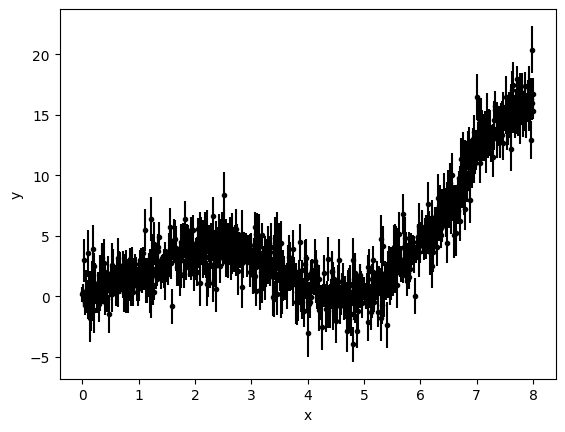

In [26]:
N = 1000 # number of training data
x = np.linspace(0, 8, N).astype(np.float32) # x-values
std = np.random.uniform(0.1, 2, N).astype(np.float32) # noise std-deviations of the measurements
y = x*np.sin(x) + x + np.random.normal(0, std).astype(np.float32) # noisy y-values

# plot the training data
plt.errorbar(x, y, yerr=std, fmt='.k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# send the training data to the device we want to work on
x = torch.unsqueeze(torch.Tensor(x), -1).to(device)
y = torch.unsqueeze(torch.Tensor(y), -1).to(device)
std = torch.unsqueeze(torch.Tensor(std), -1).to(device)

### Pytorch model for dense neural network

In [27]:
# class for general dense neural network regression
class RegressionNetwork(nn.Module):
    
    def __init__(self, n_inputs=1, # number of inputs to network
                 n_outputs=1, # number of outputs
                 n_hidden=[32, 32], # hidden layers
                 activation=[nn.LeakyReLU, nn.LeakyReLU, nn.Identity], # activation functions
                 optimizer=lambda parameters: torch.optim.Adam(parameters, lr=1e-3), # optimizer
                 initializer=lambda parameters: nn.init.normal_(parameters, mean=0., std=1e-3)): # initializer for network weights
    
        # super
        super().__init__()
        
        # architecture
        self.architecture = [n_inputs] + n_hidden + [n_outputs]
        self.n_layers = len(self.architecture) - 1
        
        # construct the network layers
        self.layers = []
        for layer in range(self.n_layers):
            
            # dense layer (with initialization if specified)
            self.layers.append(nn.Linear(self.architecture[layer], self.architecture[layer+1]))
            if initializer is not None:
                initializer(self.layers[-1].weight)
                
            # activation
            self.layers.append(activation[layer])
            
        # construct the model
        self.model = nn.Sequential(*self.layers)
                
        # optimizer
        self.optimizer = optimizer(self.model.parameters())
        
    # forward pass
    def forward(self, x):
        
        return self.model(x)
    
    # loss function
    def loss(self, x, y, std):
        
        return torch.mean((self.model(x) - y)**2 / std**2)
    
    # training step
    def training_step(self, x, y, std):
        
        # loss
        loss = self.loss(x, y, std)

        # backprop
        loss.backward()

        # update
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss
    
    # training step with accumulated gradients (if running on a large batch size that won't fit into memory)
    def training_step_accumulated_gradients(self, x, y, std, sub_batch=128):
        
        # make a data loader over the sub-batches
        dataloader = DataLoader(TensorDataset(x, y, std), batch_size=sub_batch)
        
        # loop over sub batches
        for x_, y_, std_ in dataloader:
            with torch.set_grad_enabled(True):
                
                # loss
                loss = self.loss(x_, y_, std_) * x_.shape[0] / x.shape[0]

                # backprop
                loss.backward()
                
        # update parameters
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss
    
    # fitting the model
    def fit(self, x, y, std, 
            epochs=1000,
            batch_size=128, 
            validation_split=0.1, 
            maximum_batch=10000, 
            early_stopping=True, 
            patience=20,
            device=None,
            scheduler=lambda optimizer: torch.optim.lr_scheduler(optimizer, step_size=2, gamma=0.5)):
        
        # dataset and dataloader
        dataset = TensorDataset(x, y, std)
        training_data, validation_data = torch.utils.data.random_split(dataset, [int(len(dataset)*(1.-validation_split)), len(dataset) - int(len(dataset)*(1.-validation_split))])
        training_dataloader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
        
        # learning rate scheduler
        if scheduler is not None:
            scheduler = scheduler(self.optimizer)

        # training variables
        training_loss = [np.inf]
        validation_loss = [np.inf]
        best_loss = np.inf
        best_state = self.state_dict()
        patience_counter = 0
        
        
        # main training loop
        with trange(epochs) as t:
            for epoch in t:
                for x_, y_, std_ in training_dataloader:
                    
                    # send the data batch to the same device as the model lives on
                    x_.to(device)
                    y_.to(device)
                    std_.to(device)
                    
                    # training step:
                    
                    # if your batch size is small enough to fit into memory, do a normal training step...
                    if x_.shape[0] < maximum_batch:
                        loss = self.training_step(x_, y_, std_)
                    # ...otherwise to a training step with accumulated gradients
                    else:
                        loss = self.training_step_accumulated_gradients(x_, y_, std_, sub_batch=maximum_batch)
                    
                    # update progress bar
                    t.set_postfix(ordered_dict={'training loss: ': loss.cpu().detach().numpy(),
                                                'validation loss: ': validation_loss[-1],
                                                'patience: ': patience_counter})
                                        
                # update training and validation losses
                x_, y_, std_ = validation_data[:]
                validation_loss.append(self.loss(x_, y_, std_).cpu().detach().numpy())
                training_loss.append(loss.cpu().detach().numpy())
                
                # check early stopping condition
                if early_stopping:
                    if validation_loss[-1] < best_loss:
                        best_loss = validation_loss[-1]
                        best_state = self.state_dict()
                        patience_counter = 0
                    else:
                        patience_counter += 1
                    if patience_counter > patience:
                        self.load_state_dict(best_state)
                        break
                        
                # update learning rate scheduler
                if scheduler is not None:
                    scheduler.step()
                        
        return training_loss, validation_loss


100%|██| 1000/1000 [00:12<00:00, 78.42it/s, training loss: =1.9527619, validation loss: =1.0958126, patience: =0]


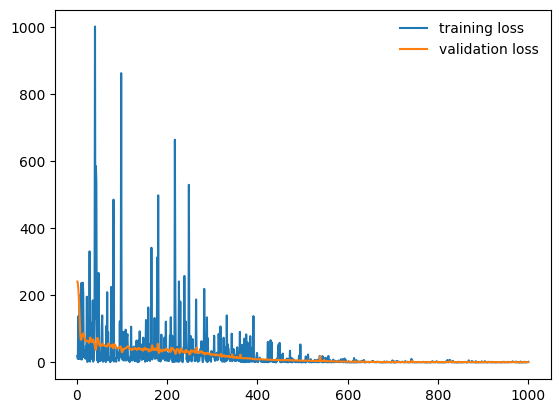

In [31]:
Model = RegressionNetwork(n_inputs=1,
                          n_outputs=1,
                          n_hidden=[64, 64],
                          activation=[nn.LeakyReLU(), nn.LeakyReLU(), nn.Identity()]).to(device)

# training parameterts
history = Model.fit(x, y, std,
                    epochs=1000,
                    validation_split=0.1, 
                    early_stopping=False, 
                    scheduler=None,
                    device=device)

plt.plot(history[0], label='training loss')
plt.plot(history[1], label='validation loss')
plt.legend(frameon=False)
plt.show()

### Plot the fit

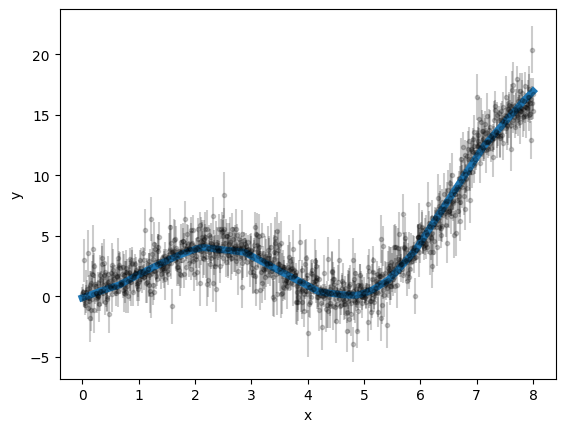

In [32]:
plt.errorbar(x.detach().numpy()[:,0], y.detach().numpy()[:,0], yerr=std.detach().numpy()[:,0], fmt='.k', alpha=0.2)
plt.plot(x.detach().numpy()[:,0], Model.forward(x).detach().numpy()[:,0], lw=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Save and restore the model

In [33]:
# save the model
torch.save(Model, 'saved_model.pt')

In [34]:
# restore the model
Model = torch.load('saved_model.pt')